In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Machine Learning in Network Science
Network representation learning
"""
%matplotlib inline
from helper import *
import os
import networkx as nx
from gensim.models import Word2Vec
from node2vec import Node2Vec
from scipy.sparse import *
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score 
from sklearn.preprocessing import LabelBinarizer 


In [2]:
# Read network files - Karate Club Network 
G = nx.read_gml("karate.gml")

print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))

# Get the node community labels and the number of communities
node2comm, num_of_communities = get_node2community(g=G)

The number of nodes: 34
The number of edges: 78


### Part I: Network Representation Learning

#### Exercise 1.1: Implementation of a random walking strategy

In [3]:
def perform_random_walks(graph, N, L):
    '''
    :param graph: networkx graph
    :param N: the number of walks for each node
    :param L: the walk length
    :return walks: the list of walks
    '''
    walks = []
    
    for node in graph.nodes():
        for _ in range(N):
            # Set the initial node
            walk = [node]
            while len(walk) < L:
                # List all nodes the walk can get to at next step
                nb_list = list(nx.neighbors(graph, walk[-1]))
                # Uniformly choose the next node at random
                nb = np.random.choice(nb_list, size=1)[0]
                walk.append(nb)
            walks.append(walk)
    
    np.random.shuffle(walks)
            
    return walks

#### Exercise 1.2: Learning representations of nodes

In [25]:
# Define parameters
num_of_walks = 100
walk_length = 8
embedding_size = 32
window_size = 6
output_filename="./graph.embedding"

# Perform random walks
walks = perform_random_walks(graph=G, N=num_of_walks, L=walk_length)
# Learn representations of nodes
model = Word2Vec(walks, size=embedding_size, window=window_size, min_count=0, workers=3)
# Save the embedding vectors
model.wv.save_word2vec_format(output_filename)

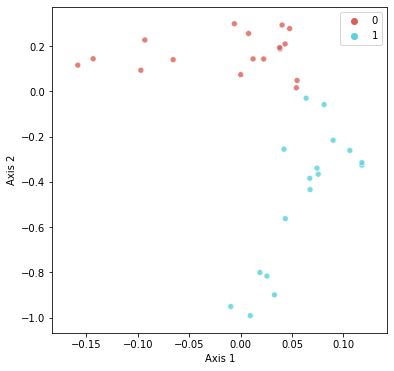

In [26]:
# Visualise the embeddings 
visualize(graph=G, node2embedding=model.wv)

### Part II: Link Predicition

In [27]:
# Functions seen in previous lab 

def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(G) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in edges:
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels


def edge_prediction(node2embedding, train_samples, test_samples, train_labels, test_labels, feature_func=None):
    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)
    
    # Fill in the blanks
    train_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in train_samples]
    test_features = [feature_func(node2embedding[edge[0]], node2embedding[edge[1]]) for edge in test_samples]
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

##### Exercise 2

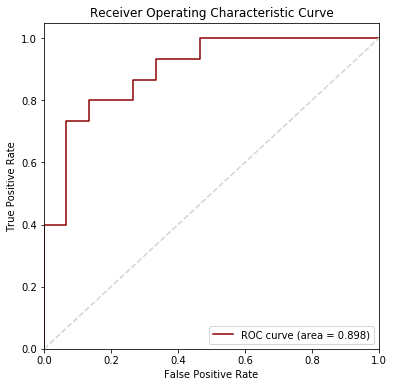

0.8977777777777778

In [28]:
# Construct the training and testing sets
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

# Perform random walks over the residual network
num_of_walks, walk_length, window_size, embedding_size = (200, 8, 5, 32)
residual_walks = perform_random_walks(graph=residual_g, N=num_of_walks, L=walk_length)

# Learn representations of nodes
model = Word2Vec(walks, size=embedding_size, sg=1, window=window_size, min_count=0, workers=3)

# Perform the edge prediction and plot the ROC curve
edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels)

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 130.80it/s]


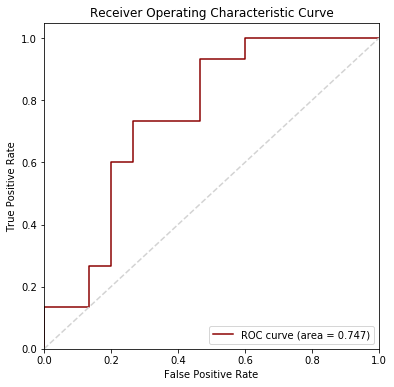

0.7466666666666666

In [29]:
# Construct the training and testing sets
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(residual_g, dimensions=128, walk_length=8, num_walks=100, workers=1, p=1, q=1)

# Embed nodes
model = node2vec.fit(window=6, min_count=1, batch_words=4)

# Perform the edge prediction and plot the ROC curve
edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels)

##### Limits of such approaches: 
    - do not include node feature information,  while it is often essential for a wide variety of tasks. Indeed, such  approaches only use graph structure information to construct embeddings. More precisely it uses p(v|u) obtained by sampling random walks to define them (see loss function of Skip-gram)
    - only capture local information, especially for DeepWalk. Higher order proximities and global graph structure are not incorporated in embeddings, since random walks do not enable to capture them. 
    - not scalable: there is no parameter sharing across nodes - each node has its own weights. This implies that as the size of the network augments, the number of parameters increases by a much larger quantity. 
    - transductive: does not generalize to modified version of the graph where we added some new nodes and edges. Need to recompute walks and embeddings. Opposite of inductive, which generalises to graph expansion/reduction. 
   

### Part III: Node Classification

#### Exercise 3

In [30]:
# Fix params
def node_classif(graph, node2embedding, train_set_ratio): 
    """Perform node classification on graph 
    
    args node2embedding: dictionnary of node embedding
    args return: accuracy score 
    """

    N = graph.number_of_nodes()

    # Get the ground-truth labels and and the total number of labels
    node2community, K = get_node2community(graph)

    # Create feature and label datasets 
    x = np.asarray([node2embedding[node] for node in graph.nodes()])
    labels = np.array([[1 if k in node2community[node] else 0 for k in range(K)] for node in G.nodes()])

    # Get the training size
    train_set_size = int(train_set_ratio * N)        

    # Shuffle the data
    shuffled_features, shuffled_labels = shuffle(x, labels)

    # Divide the data into the training and test sets
    train_features = shuffled_features[0:train_set_size, :]
    train_labels = shuffled_labels[0:train_set_size]

    test_features = shuffled_features[train_set_size:, :]
    test_labels = shuffled_labels[train_set_size:]

    # Build the model and train it
    clf = OneVsRestClassifier(LogisticRegression())
    clf.fit(train_features, train_labels)

    # Find the predictions, each node can have multiple labels
    y_pred = np.asarray(clf.predict(test_features))

    return accuracy_score(test_labels, y_pred)

node_classif(G, model.wv, 0.6)

0.9285714285714286

### Facebook page-page network

In [160]:
# Import facebook dataset  
fb_edges = pd.read_csv('musae_facebook_edges.csv')
fb_edges['id_1'], fb_edges['id_2'] = fb_edges.id_1.astype(str), fb_edges.id_2.astype(str)
graph = nx.from_pandas_edgelist(fb_edges, source='id_1', target='id_2', create_using=nx.Graph())

# Import and process labels 
fb_target = pd.read_csv('musae_facebook_target.csv')
label_names = list(fb_target['page_type'].unique())
# categorical_labels = np.array(pd.factorize(fb_target.page_type)[0])

# One hot encoding of categorical variable
label_binarizer = LabelBinarizer() 
labels = label_binarizer.fit_transform( fb_target['page_type']) 

In [162]:
# Careful: this is computationally expensive, despite having set a small parameters value

# Precompute probabilities and generate walks 
node2vec = Node2Vec(graph, dimensions=16, walk_length=10, num_walks=10, workers=1, p=1, q=1)

# Learn node embeddings
model = node2vec.fit(window=6, min_count=1, batch_words=4)





Computing transition probabilities:   0%|          | 0/22470 [00:00<?, ?it/s]



Computing transition probabilities:   0%|          | 4/22470 [00:00<11:52, 31.52it/s]



Computing transition probabilities:   0%|          | 6/22470 [00:00<18:02, 20.76it/s]



Computing transition probabilities:   0%|          | 10/22470 [00:00<15:40, 23.89it/s]



Computing transition probabilities:   0%|          | 13/22470 [00:00<16:34, 22.57it/s]



Computing transition probabilities:   0%|          | 16/22470 [00:00<18:13, 20.53it/s]



Computing transition probabilities:   0%|          | 21/22470 [00:00<15:13, 24.57it/s]



Computing transition probabilities:   0%|          | 26/22470 [00:01<14:06, 26.51it/s]



Computing transition probabilities:   0%|          | 31/22470 [00:01<15:57, 23.43it/s]



Computing transition probabilities:   0%|          | 34/22470 [00:01<19:40, 19.01it/s]



Computing transition probabilities:   0%|          | 55/22470 [00:01<14:17, 26.14it/s]



Computing transit

Computing transition probabilities:  14%|█▎        | 3074/22470 [00:28<04:06, 78.59it/s]



Computing transition probabilities:  14%|█▎        | 3085/22470 [00:28<04:43, 68.26it/s]



Computing transition probabilities:  14%|█▍        | 3098/22470 [00:28<04:06, 78.64it/s]



Computing transition probabilities:  14%|█▍        | 3109/22470 [00:28<04:08, 77.92it/s]



Computing transition probabilities:  14%|█▍        | 3129/22470 [00:28<03:22, 95.39it/s]



Computing transition probabilities:  14%|█▍        | 3143/22470 [00:28<03:03, 105.18it/s]



Computing transition probabilities:  14%|█▍        | 3156/22470 [00:29<02:57, 109.07it/s]



Computing transition probabilities:  14%|█▍        | 3173/22470 [00:29<02:38, 122.10it/s]



Computing transition probabilities:  14%|█▍        | 3214/22470 [00:29<02:10, 147.48it/s]



Computing transition probabilities:  14%|█▍        | 3236/22470 [00:29<02:01, 158.77it/s]



Computing transition probabilities:  15%|█▍        | 3261/22470 [00:29<01:4

Computing transition probabilities:  37%|███▋      | 8316/22470 [00:53<00:39, 361.56it/s]



Computing transition probabilities:  37%|███▋      | 8362/22470 [00:54<00:50, 280.75it/s]



Computing transition probabilities:  37%|███▋      | 8424/22470 [00:54<00:42, 332.59it/s]



Computing transition probabilities:  38%|███▊      | 8495/22470 [00:54<00:35, 394.57it/s]



Computing transition probabilities:  38%|███▊      | 8547/22470 [00:54<00:44, 311.90it/s]



Computing transition probabilities:  38%|███▊      | 8593/22470 [00:54<00:40, 344.85it/s]



Computing transition probabilities:  38%|███▊      | 8637/22470 [00:54<00:45, 306.71it/s]



Computing transition probabilities:  39%|███▊      | 8675/22470 [00:54<00:47, 292.68it/s]



Computing transition probabilities:  39%|███▉      | 8710/22470 [00:55<00:48, 281.32it/s]



Computing transition probabilities:  39%|███▉      | 8775/22470 [00:55<00:41, 332.50it/s]



Computing transition probabilities:  39%|███▉      | 8815/22470 [00:55